In [28]:
# Import libraries
import cv2
import os
import shutil
import numpy as np
import mahotas
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Split Dataset to Train & Testing

In [29]:
# raw name folder and output folder
raw_folders = ['dataset/augmented_1', 'dataset/augmented_2']  # raw Folder dataset
output_folder = 'split_datasets'  # Folder output
random_state = 42
test_ratio = 0.2  # 20% for test, 80% for train

def split_dataset(raw_folder):
    classes = os.listdir(raw_folder)
    
    for classe in classes:
        class_dir = os.path.join(raw_folder, classe)
        
        if not os.path.isdir(class_dir):
            continue
        
        # Path to train and test folders
        train_dest = os.path.join(output_folder, raw_folder, 'train', classe)
        test_dest = os.path.join(output_folder, raw_folder, 'test', classe)
        
        # If train and test folder exist, skip splitting
        if os.path.exists(train_dest) and os.path.exists(test_dest):
            print(f"Skipping class '{classe}' for '{raw_folder}' (already split).")
            continue
        
        # Take all file to class directory 
        file_list = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        file_list = [f for f in file_list if f != '.DS_Store']  # Skip .DS_Store files
        
        # Split train and test
        train_files, test_files = train_test_split(file_list, test_size=test_ratio, random_state=random_state)
        
        # Copy file
        for split, split_files in zip(['train', 'test'], [train_files, test_files]):
            dest_dir = os.path.join(output_folder, raw_folder, split, classe)
            os.makedirs(dest_dir, exist_ok=True)
            for file_name in split_files:
                shutil.copy(os.path.join(class_dir, file_name), os.path.join(dest_dir, file_name))


# Process both raw folders
for folder in raw_folders:
    split_dataset(folder)

print("Dataset successfully split into train and test sets.")


Skipping class 'Strawberry___healthy' for 'dataset/augmented_1' (already split).
Skipping class 'Grape___Black_rot' for 'dataset/augmented_1' (already split).
Skipping class 'Potato___Early_blight' for 'dataset/augmented_1' (already split).
Skipping class 'Blueberry___healthy' for 'dataset/augmented_1' (already split).
Skipping class 'Corn_(maize)___healthy' for 'dataset/augmented_1' (already split).
Skipping class 'Tomato___Target_Spot' for 'dataset/augmented_1' (already split).
Skipping class 'Peach___healthy' for 'dataset/augmented_1' (already split).
Skipping class 'Potato___Late_blight' for 'dataset/augmented_1' (already split).
Skipping class 'Tomato___Late_blight' for 'dataset/augmented_1' (already split).
Skipping class 'Tomato___Tomato_mosaic_virus' for 'dataset/augmented_1' (already split).
Skipping class 'Pepper,_bell___healthy' for 'dataset/augmented_1' (already split).
Skipping class 'Orange___Haunglongbing_(Citrus_greening)' for 'dataset/augmented_1' (already split).
Skip

# Load Dataset

In [30]:
# Directories
train_path_aug1 = 'split_datasets/dataset/augmented_1/train'
test_path_aug1 = 'split_datasets/dataset/augmented_1/test'
train_path_aug2 = 'split_datasets/dataset/augmented_2/train'
test_path_aug2 = 'split_datasets/dataset/augmented_2/test'

# Image Segmentation, Extract Features, Loading Dataset

In [31]:
# Image segmentation for green and brown regions
def img_segmentation(rgb_img, hsv_img):
    # Green mask (healthy regions)
    lower_green = np.array([25, 0, 20])
    upper_green = np.array([100, 255, 255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)

    # Brown mask (disease regions)
    lower_brown = np.array([10, 0, 10])
    upper_brown = np.array([30, 255, 255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)

    # Combine both masks
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

# Function to extract features
def extract_features(image):
    # Resize image for consistency
    image_resized = cv2.resize(image, (224, 224))  # Set it to 224x224 pixels

    # Preprocess: Convert to RGB and HSV
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

    # Segmentation of the image
    segmented_image = img_segmentation(image_rgb, image_hsv)

    # 1. Hu Moments
    gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
    hu_moments = cv2.HuMoments(cv2.moments(gray_segmented)).flatten()

    # 2. Haralick Features
    haralick = mahotas.features.haralick(gray_segmented).mean(axis=0)

    # 3. Histogram from RGB with smaller bins
    hist_features = cv2.calcHist(
        [segmented_image], 
        [0, 1, 2], 
        None, 
        [8, 8, 8],  # Use 8 bins
        # [32, 32, 32],  # Use 32 bins
        [0, 256, 0, 256, 0, 256]
    ).flatten()

    return hu_moments, haralick, hist_features

def load_dataset(directory):
    hu_list, haralick_list, hist_list, labels = [], [], [], []

    for label in os.listdir(directory):  # Loop through class directories
        if label == '.DS_Store':
            continue  # Skip macOS system files
        label_path = os.path.join(directory, label)
        if not os.path.isdir(label_path):
            continue  # Skip if it's not a directory
        for img_file in os.listdir(label_path):  # Loop through images
            if img_file == '.DS_Store':
                continue  # Skip macOS system files
            img_path = os.path.join(label_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:  # Ensure the image is loaded correctly
                # Extract features from the image
                hu, haralick, hist = extract_features(image)
                hu_list.append(hu)
                haralick_list.append(haralick)
                hist_list.append(hist)
                labels.append(label)
            else:
                print(f"Warning: Unable to load image {img_path}")
    
    # Convert lists to NumPy arrays
    return np.array(hu_list), np.array(haralick_list), np.array(hist_list), np.array(labels)

# Loading Dataset for training

In [32]:
# Load datasets for both augmented splits
hu_train_1, haralick_train_1, hist_train_1, y_train_1 = load_dataset(train_path_aug1)
hu_test_1, haralick_test_1, hist_test_1, y_test_1 = load_dataset(test_path_aug1)

hu_train_2, haralick_train_2, hist_train_2, y_train_2 = load_dataset(train_path_aug2)
hu_test_2, haralick_test_2, hist_test_2, y_test_2 = load_dataset(test_path_aug2)

#Shuffle datasets
hu_train_1, haralick_train_1, hist_train_1, y_train_1 = shuffle(hu_train_1, haralick_train_1, hist_train_1, y_train_1, random_state=42)
hu_test_1, haralick_test_1, hist_test_1, y_test_1 = shuffle(hu_test_1, haralick_test_1, hist_test_1, y_test_1, random_state=42)
hu_train_2, haralick_train_2, hist_train_2, y_train_2 = shuffle(hu_train_2, haralick_train_2, hist_train_2, y_train_2, random_state=42)
hu_test_2, haralick_test_2, hist_test_2, y_test_2 = shuffle(hu_test_2, haralick_test_2, hist_test_2, y_test_2, random_state=42)

# Encode Labels, Scaler, Feature Combinations

In [33]:
# Encode Labels
encoder = LabelEncoder()
y_train_1_encoded = encoder.fit_transform(y_train_1)
y_test_1_encoded = encoder.transform(y_test_1)

y_train_2_encoded = encoder.fit_transform(y_train_2)
y_test_2_encoded = encoder.transform(y_test_2)

# Scale Features
scaler = StandardScaler()

feature_combinations = {
    # Dataset Aug 1 - Individual Features
    "Hu Moments - Aug 1": (hu_train_1, hu_test_1),
    "Haralick Features - Aug 1": (haralick_train_1, haralick_test_1),
    "Histogram - Aug 1": (hist_train_1, hist_test_1),
    

    # Dataset Aug 1 - Combined Features
    "Hu + Haralick - Aug 1": (
        np.hstack([hu_train_1, haralick_train_1]),
        np.hstack([hu_test_1, haralick_test_1])
    ),
    "Hu + Histogram - Aug 1": (
        np.hstack([hu_train_1, hist_train_1]),
        np.hstack([hu_test_1, hist_test_1])
    ),
    "Histogram + Haralick - Aug 1": (
        np.hstack([hist_train_1, haralick_train_1]),
        np.hstack([hist_test_1, haralick_test_1])
    ),
    "All Features - Aug 1": (
        np.hstack([hu_train_1, haralick_train_1, hist_train_1]),
        np.hstack([hu_test_1, haralick_test_1, hist_test_1])
    ),
    # Dataset Aug 2 - Individual Features
    "Hu Moments - Aug 2": (hu_train_2, hu_test_2),
    "Haralick Features - Aug 2": (haralick_train_2, haralick_test_2),
    "Histogram - Aug 2": (hist_train_2, hist_test_2),
    
    # Dataset Aug 2 - Combined Features
    "Hu + Haralick - Aug 2": (
        np.hstack([hu_train_2, haralick_train_2]),
        np.hstack([hu_test_2, haralick_test_2])
    ),
    "Hu + Histogram - Aug 2": (
        np.hstack([hu_train_2, hist_train_2]),
        np.hstack([hu_test_2, hist_test_2])
    ),
    "Histogram + Haralick - Aug 2": (
        np.hstack([hist_train_2, haralick_train_2]),
        np.hstack([hist_test_2, haralick_test_2])
    ),
    "All Features - Aug 2": (
        np.hstack([hu_train_2, haralick_train_2, hist_train_2]),
        np.hstack([hu_test_2, haralick_test_2, hist_test_2])
    )
}


# Modelling

In [34]:
# Initialize models
svm = SVC(kernel='linear', random_state=42)

# Header with fixed column width
print("Comparison of Feature Combinations and Model Accuracy:")
header = f"{'Feature Combination':<30}{'SVM':<20}"
print(header)
print("-" * len(header))

# Loop over all feature combinations and train with respective datasets
for name in feature_combinations.keys():

    # Initialize accuracy variables
    acc_svm_1 = acc_svm_2 = None

    if "Aug 1" in name:
        # Dataset 1
        X_train_1, X_test_1 = feature_combinations[name]
        X_train_scaled_1 = scaler.fit_transform(X_train_1)
        X_test_scaled_1 = scaler.transform(X_test_1)
        svm.fit(X_train_scaled_1, y_train_1_encoded)
        y_pred_svm_1 = svm.predict(X_test_scaled_1)
        acc_svm_1 = accuracy_score(y_test_1_encoded, y_pred_svm_1)

    if "Aug 2" in name:
        # Dataset 2
        X_train_2, X_test_2 = feature_combinations[name]
        X_train_scaled_2 = scaler.fit_transform(X_train_2)
        X_test_scaled_2 = scaler.transform(X_test_2)
        svm.fit(X_train_scaled_2, y_train_2_encoded)
        y_pred_svm_2 = svm.predict(X_test_scaled_2)
        acc_svm_2 = accuracy_score(y_test_2_encoded, y_pred_svm_2)

    # Print results
    row = f"{name:<30}{(f'{acc_svm_1:.4f}' if acc_svm_1 is not None else f'{acc_svm_2:.4f}'):<20}"
    print(row)


Comparison of Feature Combinations and Model Accuracy:
Feature Combination           SVM                 
--------------------------------------------------
Hu Moments - Aug 1            0.1260              
Haralick Features - Aug 1     0.4676              
Histogram - Aug 1             0.8131              
Hu + Haralick - Aug 1         0.5113              
Hu + Histogram - Aug 1        0.8286              
Histogram + Haralick - Aug 1  0.8607              
All Features - Aug 1          0.8684              
Hu Moments - Aug 2            0.1554              
Haralick Features - Aug 2     0.5144              
Histogram - Aug 2             0.8413              
Hu + Haralick - Aug 2         0.5762              
Hu + Histogram - Aug 2        0.8536              
Histogram + Haralick - Aug 2  0.8788              
All Features - Aug 2          0.8876              


| Label                                  | Encoded Value |
|----------------------------------------|---------------|
| Apple___Apple_scab                     | 0             |
| Apple___Black_rot                      | 1             |
| Apple___Cedar_apple_rust               | 2             |
| Apple___healthy                        | 3             |
| Blueberry___healthy                    | 4             |
| Cherry_(including_sour)___healthy      | 5             |
| Cherry_(including_sour)___Powdery_mildew | 6           |
| Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot | 7 |
| Corn_(maize)___Common_rust_            | 8             |
| Corn_(maize)___healthy                 | 9             |
| Corn_(maize)___Northern_Leaf_Blight    | 10            |
| Grape___Black_rot                      | 11            |
| Grape___Esca_(Black_Measles)           | 12            |
| Grape___healthy                        | 13            |
| Grape___Leaf_blight_(Isariopsis_Leaf_Spot) | 14         |
| Orange___Haunglongbing_(Citrus_greening) | 15          |
| Peach___Bacterial_spot                 | 16            |
| Peach___healthy                        | 17            |
| Pepper,_bell___Bacterial_spot          | 18            |
| Pepper,_bell___healthy                 | 19            |
| Potato___Early_blight                  | 20            |
| Potato___healthy                       | 21            |
| Potato___Late_blight                   | 22            |
| Raspberry___healthy                    | 23            |
| Soybean___healthy                      | 24            |
| Squash___Powdery_mildew                | 25            |
| Strawberry___healthy                   | 26            |
| Strawberry___Leaf_scorch               | 27            |
| Tomato___Bacterial_spot                | 28            |
| Tomato___Early_blight                  | 29            |
| Tomato___healthy                       | 30            |
| Tomato___Late_blight                   | 31            |
| Tomato___Leaf_Mold                     | 32            |
| Tomato___Septoria_leaf_spot            | 33            |
| Tomato___Spider_mites_Two-spotted_spider_mite | 34     |
| Tomato___Target_Spot                   | 35            |
| Tomato___Tomato_mosaic_virus           | 36            |
| Tomato___Tomato_Yellow_Leaf_Curl_Virus | 37            |


# Evaluation for each Dataset


Final Evaluation on All Features for Dataset 1 (SVM):
SVM Classification Report (Dataset 1):
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.76      0.85      0.80       252
                                 Apple___Black_rot       0.90      0.91      0.90       249
                          Apple___Cedar_apple_rust       0.89      0.94      0.91       220
                                   Apple___healthy       0.73      0.78      0.75       200
                               Blueberry___healthy       0.90      0.95      0.92       200
          Cherry_(including_sour)___Powdery_mildew       0.85      0.84      0.85       200
                 Cherry_(including_sour)___healthy       0.85      0.91      0.88       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.81      0.81       206
                       Corn_(maize)___Common_rust_       0.90      0.93      

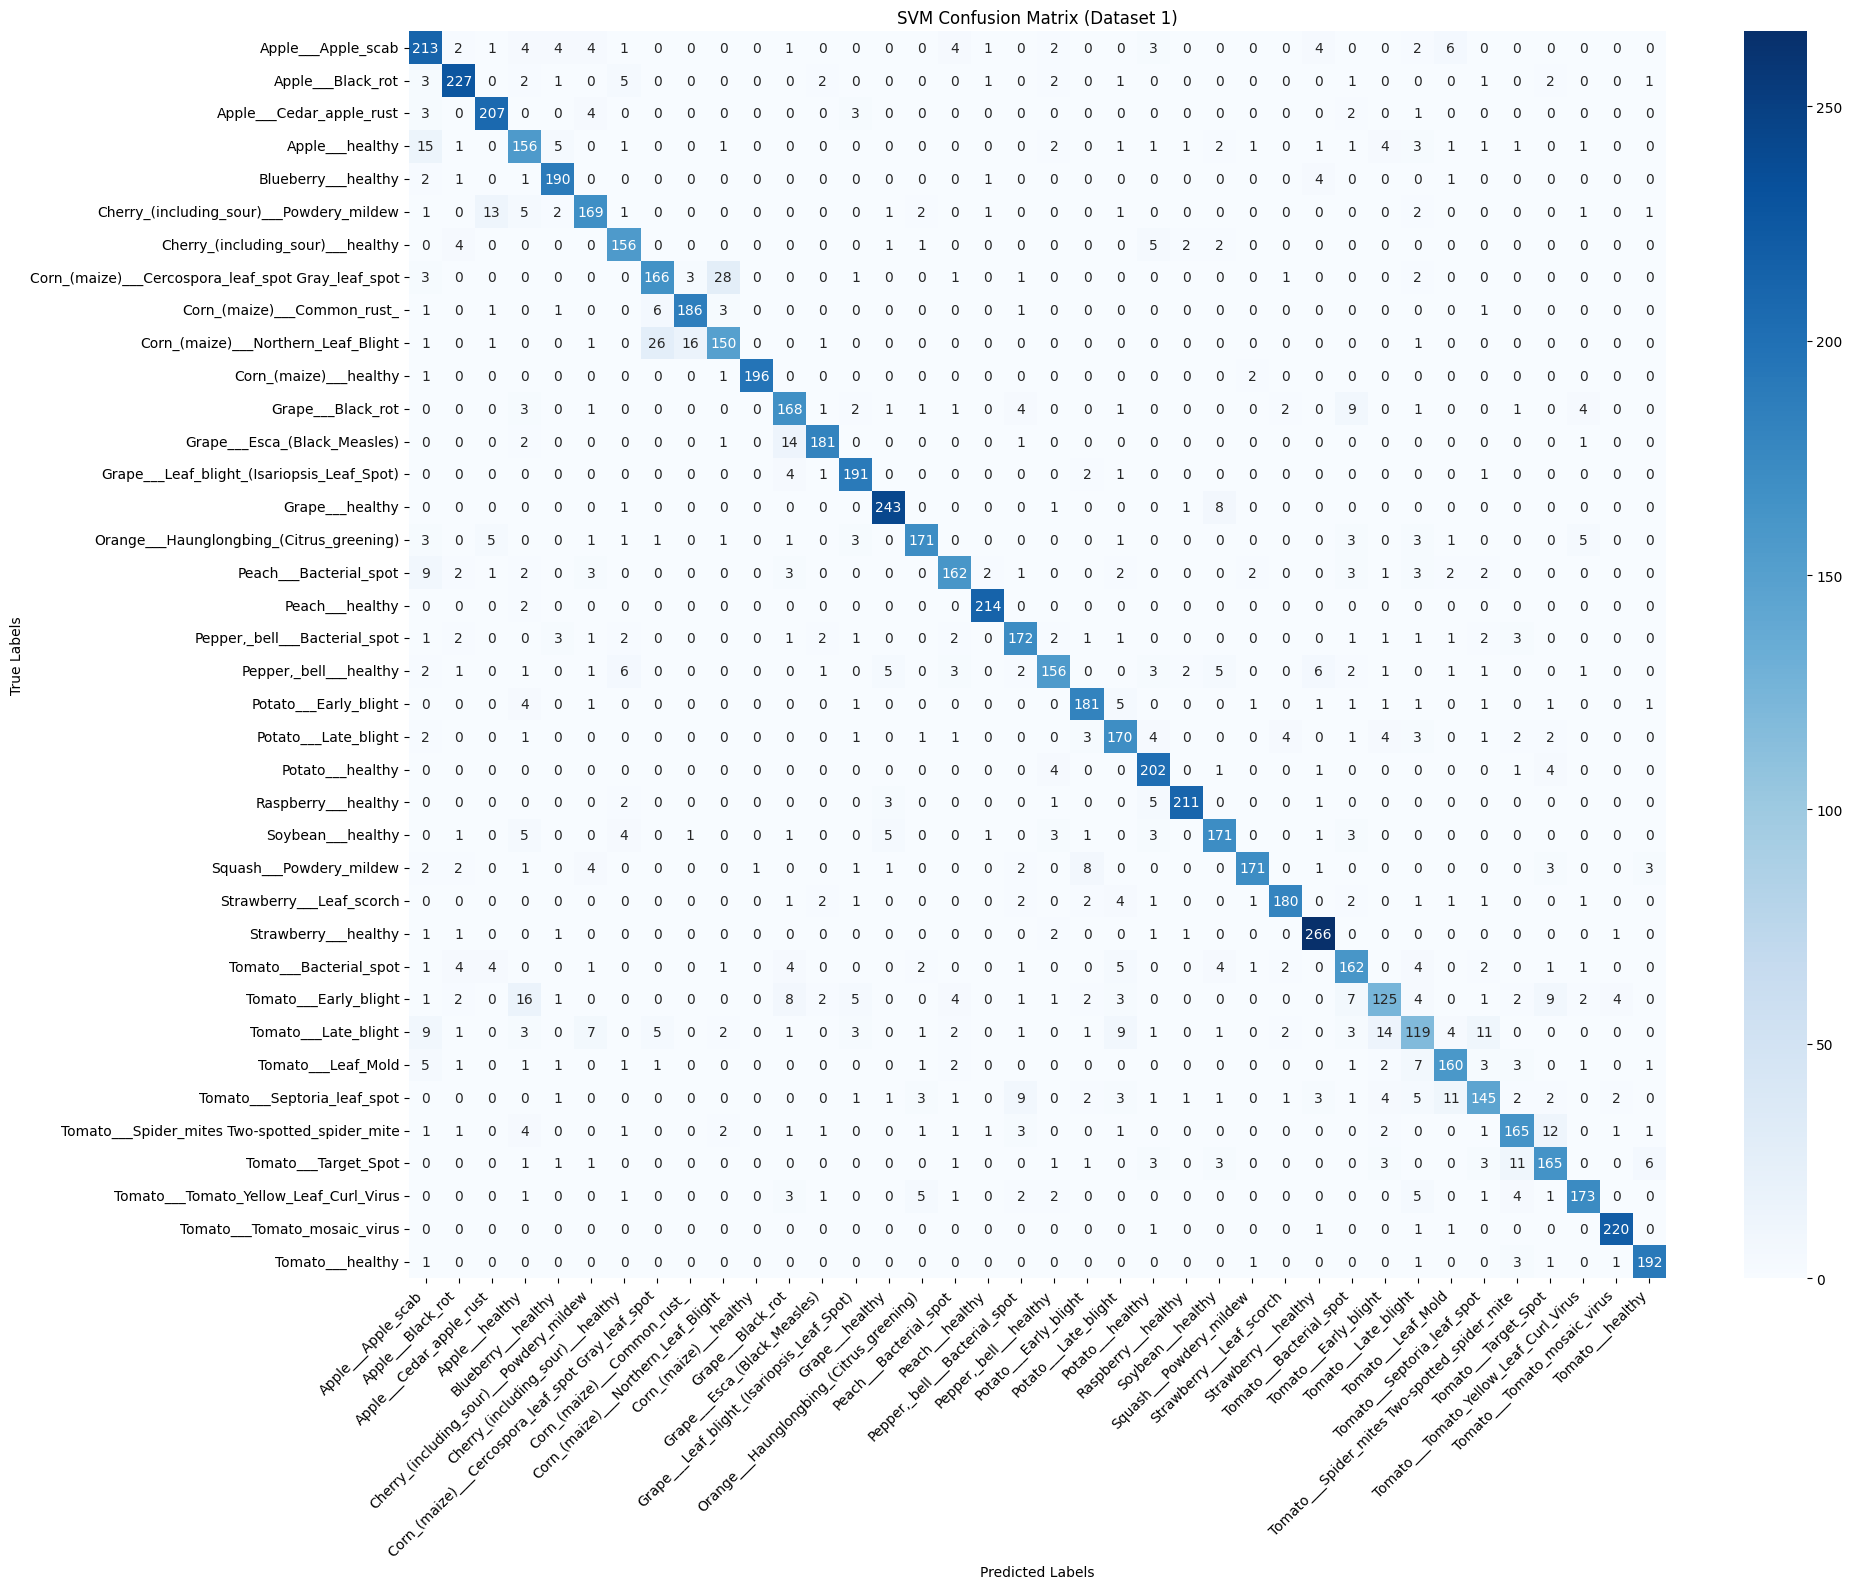


Final Evaluation on All Features for Dataset 2 (SVM):
SVM Classification Report (Dataset 2):
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.75      0.91      0.82       252
                                 Apple___Black_rot       0.90      0.97      0.93       249
                          Apple___Cedar_apple_rust       0.92      0.96      0.94       220
                                   Apple___healthy       0.74      0.77      0.76       200
                               Blueberry___healthy       0.95      0.94      0.94       200
          Cherry_(including_sour)___Powdery_mildew       0.88      0.86      0.87       200
                 Cherry_(including_sour)___healthy       0.89      0.92      0.91       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.77      0.80      0.79       206
                       Corn_(maize)___Common_rust_       0.92      0.92      

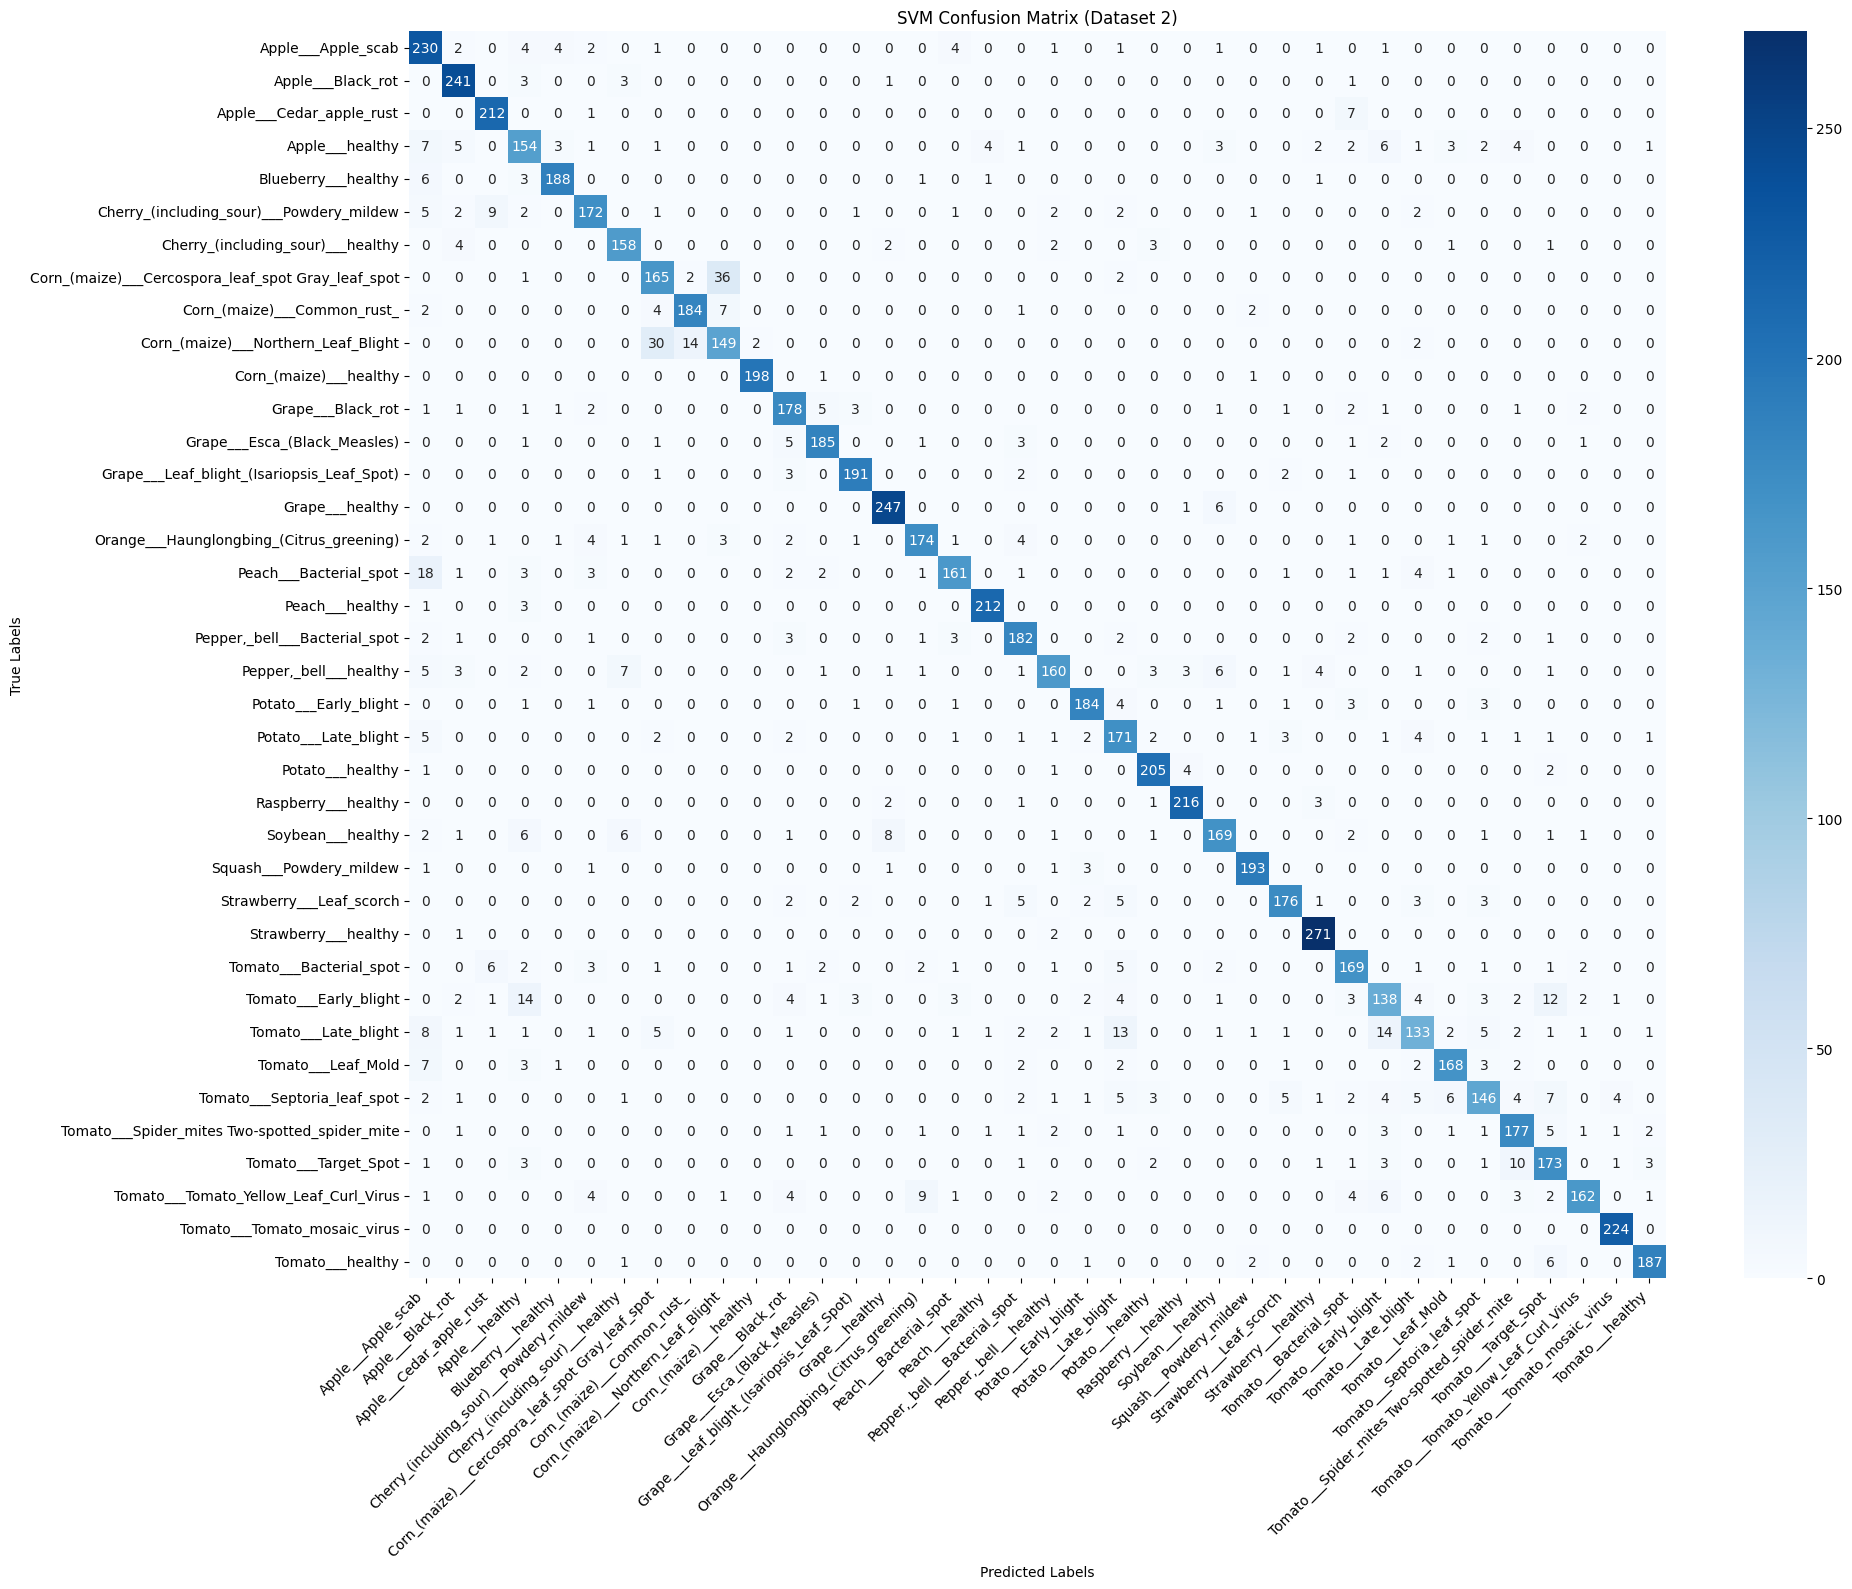

In [43]:
# Final Evaluation on All Features for SVM
print("\nFinal Evaluation on All Features for Dataset 1 (SVM):")
svm.fit(X_train_scaled_1, y_train_1_encoded)
y_pred_svm_1 = svm.predict(X_test_scaled_1)

# Inverse transform the encoded labels to original class names
y_test_1_original = encoder.inverse_transform(y_test_1_encoded)
y_pred_svm_1_original = encoder.inverse_transform(y_pred_svm_1)

print("SVM Classification Report (Dataset 1):")
print(classification_report(y_test_1_original, y_pred_svm_1_original))

class_labels = encoder.classes_
# Plot Confusion Matrix for Dataset 1
conf_matrix_svm_1 = confusion_matrix(y_test_1_original, y_pred_svm_1_original)
plt.figure(figsize=(20, 16))  
sns.heatmap(conf_matrix_svm_1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("SVM Confusion Matrix (Dataset 1)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Rotate labels on the X-axis to prevent overlap
plt.xticks(rotation=45, ha="right")  # Rotate to the right at 45 degrees
plt.yticks(rotation=0)  # No rotation needed for Y-axis labels
plt.tight_layout()
plt.show()

print("\nFinal Evaluation on All Features for Dataset 2 (SVM):")
svm.fit(X_train_scaled_2, y_train_2_encoded)
y_pred_svm_2 = svm.predict(X_test_scaled_2)

# Inverse transform the encoded labels to original class names
y_test_2_original = encoder.inverse_transform(y_test_2_encoded)
y_pred_svm_2_original = encoder.inverse_transform(y_pred_svm_2)

print("SVM Classification Report (Dataset 2):")
print(classification_report(y_test_2_original, y_pred_svm_2_original))

# Plot Confusion Matrix for Dataset 2
conf_matrix_svm_2 = confusion_matrix(y_test_2_original, y_pred_svm_2_original)
plt.figure(figsize=(20, 16))  
sns.heatmap(conf_matrix_svm_2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("SVM Confusion Matrix (Dataset 2)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Rotate labels on the X-axis to prevent overlap
plt.xticks(rotation=45, ha="right")  # Rotate to the right at 45 degrees
plt.yticks(rotation=0)  # No rotation needed for Y-axis labels
plt.tight_layout()
plt.show()


# Saving Models for Both Datasets

In [36]:
# Train SVM and save models
svm.fit(X_train_scaled_1, y_train_1_encoded)
with open('svm_model_dataset1.pkl', 'wb') as f:
    pickle.dump(svm, f)
print("SVM model for Dataset 1 saved.")

svm.fit(X_train_scaled_2, y_train_2_encoded)
with open('svm_model_dataset2.pkl', 'wb') as f:
    pickle.dump(svm, f)
print("SVM model for Dataset 2 saved.")

SVM model for Dataset 1 saved.
SVM model for Dataset 2 saved.


# Loading Models for Both Datasets

In [37]:
# Load SVM models
with open('svm_model_dataset1.pkl', 'rb') as f:
    loaded_svm_dataset1 = pickle.load(f)
print("SVM model for Dataset 1 loaded.")

with open('svm_model_dataset2.pkl', 'rb') as f:
    loaded_svm_dataset2 = pickle.load(f)
print("SVM model for Dataset 2 loaded.")

SVM model for Dataset 1 loaded.
SVM model for Dataset 2 loaded.


# Using the Loaded Model for Prediction

In [38]:
# Use loaded SVM models for predictions
y_pred_svm_dataset1 = loaded_svm_dataset1.predict(X_test_scaled_1)
y_pred_svm_dataset2 = loaded_svm_dataset2.predict(X_test_scaled_2)

# Print sample results
original_labels_svm_dataset1 = encoder.inverse_transform(y_pred_svm_dataset1[:100])
original_labels_svm_dataset2 = encoder.inverse_transform(y_pred_svm_dataset2[:100])

print("Predictions using loaded SVM model for Dataset 1 (Original Labels):", original_labels_svm_dataset1)
print("Predictions using loaded SVM model for Dataset 2 (Original Labels):", original_labels_svm_dataset2)

Predictions using loaded SVM model for Dataset 1 (Original Labels): ['Tomato___Tomato_mosaic_virus' 'Peach___Bacterial_spot'
 'Tomato___Late_blight' 'Apple___Cedar_apple_rust'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
 'Orange___Haunglongbing_(Citrus_greening)' 'Strawberry___Leaf_scorch'
 'Corn_(maize)___Common_rust_' 'Soybean___healthy'
 'Tomato___Bacterial_spot' 'Peach___healthy' 'Pepper,_bell___healthy'
 'Tomato___Leaf_Mold' 'Corn_(maize)___Common_rust_' 'Potato___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Raspberry___healthy' 'Tomato___Leaf_Mold'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Potato___Early_blight'
 'Peach___Bacterial_spot' 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
 'Squash___Powdery_mildew' 'Potato___healthy'
 'Tomato___Tomato_mosaic_virus' 'Grape___Black_rot' 'Apple___Black_rot'
 'Orange___Haunglongbing_(Citrus_greening)'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Apple___Cedar